# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [2]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

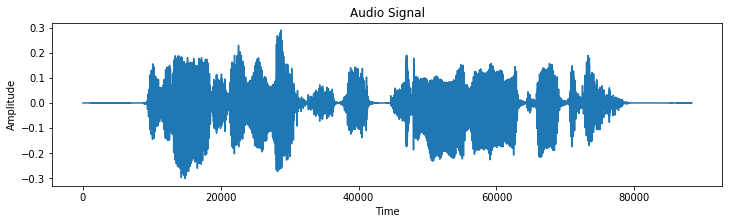

**Shape of Audio Signal** : (88311,)

**Transcript** : we remained several months but soon we were on the tramp again

In [3]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

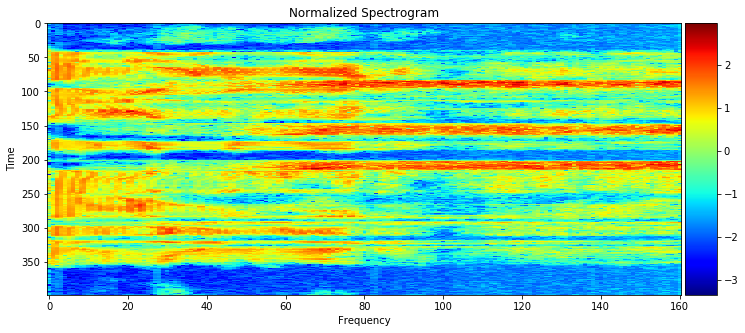

**Shape of Spectrogram** : (399, 161)

In [4]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

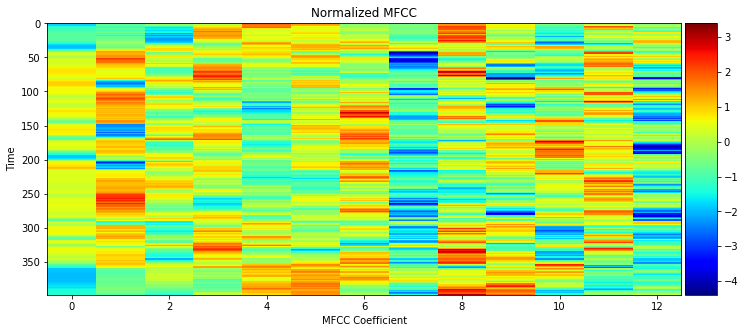

**Shape of MFCC** : (399, 13)

In [5]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [9]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [2]:
model_0 = simple_rnn_model(input_dim=13) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          3741      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [ ]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=False,
            optimizer='adam') # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 265s - loss: 1286.5552 - val_loss: 1030.8432
Epoch 2/20
106/106 [==============================] - 243s - loss: 863.1430 - val_loss: 775.2508
Epoch 3/20
106/106 [==============================] - 244s - loss: 796.8674 - val_loss: 761.9986
Epoch 4/20
106/106 [==============================] - 247s - loss: 769.2974 - val_loss: 738.2856
Epoch 5/20
106/106 [==============================] - 246s - loss: 757.0986 - val_loss: 730.8434
Epoch 6/20
106/106 [==============================] - 246s - loss: 756.6104 - val_loss: 727.5395
Epoch 7/20
106/106 [==============================] - 246s - loss: 755.0915 - val_loss: 723.8911
Epoch 10/20
106/106 [==============================] - 248s - loss: 754.9712 - val_loss: 735.0498
Epoch 11/20
106/106 [==============================] - 247s - loss: 754.2702 - val_loss: 728.9630
Epoch 12/20
106/106 [==============================] - 248s - loss: 753.1338 - val_loss: 728.1276
Epoch 13/20
106/106 [====

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [10]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [11]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 295s 3s/step - loss: 297.1671 - val_loss: 214.4508
Epoch 2/20
106/106 [==============================] - 289s 3s/step - loss: 207.5862 - val_loss: 202.9714
Epoch 3/20
106/106 [==============================] - 273s 3s/step - loss: 185.3107 - val_loss: 180.2566
Epoch 4/20
106/106 [==============================] - 261s 2s/step - loss: 167.5040 - val_loss: 160.1623
Epoch 5/20
106/106 [==============================] - 258s 2s/step - loss: 157.1951 - val_loss: 156.0914
Epoch 6/20
106/106 [==============================] - 258s 2s/step - loss: 150.1633 - val_loss: 150.3899
Epoch 7/20
106/106 [==============================] - 251s 2s/step - loss: 144.6468 - val_loss: 145.3603
Epoch 8/20
106/106 [==============================] - 249s 2s/step - loss: 141.7504 - val_loss: 147.9575
Epoch 9/20
106/106 [==============================] - 249s 2s/step - loss: 138.7065 - val_loss: 144.7078
Epoch 10/20
106/106 [==============================] - 

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [12]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
___________________________________________________________

/home/andrzej/.conda/envs/aind-cv-vui/lib/python3.5/site-packages/keras/layers/recurrent.py:1028: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [13]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 93s 880ms/step - loss: 237.2023 - val_loss: 216.6932
Epoch 2/20
106/106 [==============================] - 94s 889ms/step - loss: 192.1988 - val_loss: 173.4974
Epoch 3/20
106/106 [==============================] - 95s 895ms/step - loss: 158.4810 - val_loss: 154.1039
Epoch 4/20
106/106 [==============================] - 95s 893ms/step - loss: 143.4823 - val_loss: 146.6441
Epoch 5/20
106/106 [==============================] - 95s 895ms/step - loss: 134.0711 - val_loss: 138.8741
Epoch 6/20
106/106 [==============================] - 95s 893ms/step - loss: 127.3989 - val_loss: 132.9053
Epoch 7/20
106/106 [==============================] - 94s 891ms/step - loss: 121.8686 - val_loss: 134.0118
Epoch 8/20
106/106 [==============================] - 95s 896ms/step - loss: 117.0871 - val_loss: 129.8389
Epoch 9/20
106/106 [==============================] - 95s 899ms/step - loss: 113.0816 - val_loss: 132.8408
Epoch 10/20
106/106 [================

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [41]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

2
Tensor("batch_normalization_36/cond/Merge:0", shape=(?, ?, 200), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_35 (Batc (None, None, 200)         800       
_________________________________________________________________
gru_2 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_36 (Batc (None, None, 200)         800       
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 29)          5829      
____________________________________________________________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [49]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 455s 4s/step - loss: 110.9732 - val_loss: 141.7276
Epoch 2/20
106/106 [==============================] - 464s 4s/step - loss: 105.9091 - val_loss: 124.9360
Epoch 3/20
106/106 [==============================] - 463s 4s/step - loss: 102.0551 - val_loss: 123.0280
Epoch 4/20
106/106 [==============================] - 463s 4s/step - loss: 99.6367 - val_loss: 124.8798
Epoch 5/20
106/106 [==============================] - 460s 4s/step - loss: 97.7512 - val_loss: 120.5234
Epoch 6/20
106/106 [==============================] - 462s 4s/step - loss: 94.9915 - val_loss: 121.3755
Epoch 7/20
106/106 [==============================] - 461s 4s/step - loss: 93.3472 - val_loss: 120.7730
Epoch 8/20
106/106 [==============================] - 459s 4s/step - loss: 91.1764 - val_loss: 119.2353
Epoch 9/20
106/106 [==============================] - 462s 4s/step - loss: 89.8431 - val_loss: 119.2985
Epoch 10/20
106/106 [==============================] - 461s 4

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [47]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [48]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 302s 3s/step - loss: 274.0065 - val_loss: 220.5564
Epoch 2/20
106/106 [==============================] - 276s 3s/step - loss: 215.0255 - val_loss: 199.5410
Epoch 3/20
106/106 [==============================] - 266s 3s/step - loss: 200.7885 - val_loss: 189.3762
Epoch 4/20
106/106 [==============================] - 269s 3s/step - loss: 192.1533 - val_loss: 184.6046
Epoch 5/20
106/106 [==============================] - 276s 3s/step - loss: 183.3199 - val_loss: 177.4905
Epoch 6/20
106/106 [==============================] - 291s 3s/step - loss: 176.0736 - val_loss: 171.8844
Epoch 7/20
106/106 [==============================] - 276s 3s/step - loss: 168.0863 - val_loss: 164.3484
Epoch 8/20
106/106 [==============================] - 266s 3s/step - loss: 161.3479 - val_loss: 161.0513
Epoch 9/20
106/106 [==============================] - 287s 3s/step - loss: 155.0466 - val_loss: 157.7390
Epoch 10/20
106/106 [==============================] - 

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [68]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM, Dropout)

def deep_bidirectional_rnn_model(input_dim, units, recur_layers, output_dim=29):
    """ Build a deep recurrent network for speech 
    """
    
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    
    recurnn_layers=[]
    batchnm_layers=[]
    #dropout_layers=[]
    dropout_prob = 0.1
    
    recurnn_layers.append(Bidirectional(GRU(units, activation='relu',
                                            return_sequences=True, implementation=2, name='rnn', 
                                            dropout_U=dropout_prob), 
                                        merge_mode='concat')(input_data))
    
    batchnm_layers.append(BatchNormalization()(recurnn_layers[0]))
    #dropout_layers.append(Dropout(keep_prob)(batchnm_layers[0]))
    
    for i in range(1,recur_layers):
        
        recurnn_layers.append(Bidirectional(GRU(units, activation='relu',
                                                return_sequences=True, implementation=2,
                                               dropout_U=dropout_prob), 
                                            merge_mode='concat')(batchnm_layers[i-1]))
        
        batchnm_layers.append(BatchNormalization()(recurnn_layers[i]))
        #dropout_layers.append(Dropout(keep_prob)(batchnm_layers[i]))

    
    
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(batchnm_layers[recur_layers-1])
    
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [67]:
model_5 = deep_bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

/home/andrzej/.conda/envs/aind-cv-vui/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(200, activation="relu", recurrent_dropout=0.1, return_sequences=True, name="rnn")`
/home/andrzej/.conda/envs/aind-cv-vui/lib/python3.5/site-packages/ipykernel/__main__.py:31: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(200, activation="relu", recurrent_dropout=0.1, return_sequences=True)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, None, 400)         434400    
_________________________________________________________________
batch_normalization_48 (Batc (None, None, 400)         1600      
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 400)         721200    
_________________________________________________________________
batch_normalization_49 (Batc (None, None, 400)         1600      
_________________________________________________________________
time_distributed_25 (TimeDis (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [69]:
train_model(input_to_softmax=model_5, 
            pickle_path='model_5.pickle', 
            save_model_path='model_5.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 657s 6s/step - loss: 271.1398 - val_loss: 223.9517
Epoch 2/20
106/106 [==============================] - 675s 6s/step - loss: 224.3565 - val_loss: 201.8755
Epoch 3/20
106/106 [==============================] - 661s 6s/step - loss: 199.5581 - val_loss: 179.6474
Epoch 4/20
106/106 [==============================] - 659s 6s/step - loss: 167.7102 - val_loss: 152.9572
Epoch 5/20
106/106 [==============================] - 641s 6s/step - loss: 148.7438 - val_loss: 142.6506
Epoch 6/20
106/106 [==============================] - 628s 6s/step - loss: 137.0460 - val_loss: 133.1503
Epoch 7/20
106/106 [==============================] - 631s 6s/step - loss: 127.7529 - val_loss: 131.4369
Epoch 8/20
106/106 [==============================] - 674s 6s/step - loss: 120.5022 - val_loss: 125.3741
Epoch 9/20
106/106 [==============================] - 651s 6s/step - loss: 114.2250 - val_loss: 124.0679
Epoch 10/20
106/106 [==============================] - 

## Next try - similar to Mozilla deepspeech

https://arxiv.org/pdf/1412.5567.pdf

They use a 5-layer network: 3 non-recurrent input layers, one bi-directional recurrent layer, time-independent dense layer.

SimpleRNN didn't work because of exploding gradients (``nan`` in ``val_loss``), so I switched to GRU.

```
Epoch 1/20
106/106 [==============================] - 160s 2s/step - loss: 317.8242 - val_loss: 333.6111
Epoch 2/20
106/106 [==============================] - 160s 2s/step - loss: 240.1940 - val_loss: 352.8092
Epoch 3/20
106/106 [==============================] - 159s 2s/step - loss: 230.2839 - val_loss: 298.0587
Epoch 4/20
106/106 [==============================] - 158s 1s/step - loss: 224.7023 - val_loss: 286.7940
Epoch 5/20
106/106 [==============================] - 158s 1s/step - loss: 220.5014 - val_loss: 276.5635
Epoch 6/20
106/106 [==============================] - 158s 1s/step - loss: 218.0747 - val_loss: 274.8617
Epoch 7/20
106/106 [==============================] - 159s 1s/step - loss: 216.5969 - val_loss: 272.5335
Epoch 8/20
106/106 [==============================] - 158s 1s/step - loss: 213.7117 - val_loss: 254.0279
Epoch 9/20
106/106 [==============================] - 158s 1s/step - loss: 210.4404 - val_loss: 229.5966
Epoch 10/20
106/106 [==============================] - 152s 1s/step - loss: 203.5027 - val_loss: nan
Epoch 11/20
106/106 [==============================] - 153s 1s/step - loss: 190.2610 - val_loss: nan
```



In [50]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM, Dropout)

def deep_bidirectional_simplernn_model(input_dim, units, output_dim=29):
    """ Build a deep recurrent network for speech 
    """
    
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense1 = TimeDistributed(Dense(128))(input_data)
    time_dense2 = TimeDistributed(Dense(64))(time_dense1)
    time_dense3 = TimeDistributed(Dense(64))(time_dense2)
    
    recurnn_layers=[]
    batchnm_layers=[]
    #dropout_layers=[]
    dropout_prob = 0.1
    
    recurnn_layers.append(Bidirectional(SimpleRNN(units, activation='relu',
                                            return_sequences=True, implementation=2, name='rnn', 
                                            dropout_U=dropout_prob), 
                                        merge_mode='concat')(time_dense3))
    
    batchnm_layers.append(BatchNormalization()(recurnn_layers[0]))
    
    
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    dense = Dense(output_dim)(batchnm_layers[0])
    
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(dense)
    
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [51]:
model_6 = deep_bidirectional_simplernn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200) 

/home/andrzej/.conda/envs/aind-vui/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(200, recurrent_dropout=0.1, activation="relu", return_sequences=True, name="rnn", implementation=2)`
/home/andrzej/.conda/envs/aind-vui/lib/python3.5/site-packages/keras/layers/recurrent.py:1028: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 128)         1792      
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 64)          8256      
_________________________________________________________________
time_distributed_21 (TimeDis (None, None, 64)          4160      
_________________________________________________________________
bidirectional_21 (Bidirectio (None, None, 400)         106000    
_________________________________________________________________
batch_normalization_21 (Batc (None, None, 400)         1600      
_________________________________________________________________
dense_25 (Dense)             (None, None, 29)          11629     
__________

In [52]:
train_model(input_to_softmax=model_6, 
            pickle_path='model_6.pickle', 
            save_model_path='model_6.h5', 
            spectrogram=False,
            optimizer='adam'
            ) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 161s 2s/step - loss: 302.8929 - val_loss: 249.4101
Epoch 2/20
106/106 [==============================] - 158s 1s/step - loss: 237.2261 - val_loss: 219.7635
Epoch 3/20
106/106 [==============================] - 158s 1s/step - loss: 230.1052 - val_loss: 213.3136
Epoch 4/20
106/106 [==============================] - 158s 1s/step - loss: 225.8005 - val_loss: 211.4328
Epoch 5/20
106/106 [==============================] - 158s 1s/step - loss: 224.4497 - val_loss: 211.5225
Epoch 6/20
106/106 [==============================] - 159s 1s/step - loss: 217.5182 - val_loss: 209.2871
Epoch 7/20
106/106 [==============================] - 158s 1s/step - loss: 214.6796 - val_loss: 207.3398
Epoch 8/20
106/106 [==============================] - 159s 1s/step - loss: 212.6007 - val_loss: 217.9564
Epoch 9/20
106/106 [==============================] - 157s 1s/step - loss: 206.7561 - val_loss: 199.4027
Epoch 10/20
106/106 [==============================] - 

In [14]:
# Deeper RNN
model_7 = deep_bidirectional_lstm_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=5) 

/home/andrzej/.conda/envs/aind-vui/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`
/home/andrzej/.conda/envs/aind-vui/lib/python3.5/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 400)         342400    
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 400)         1600      
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 400)         961600    
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 400)         1600      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, None, 400)         961600    
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 400)         1600      
__________

In [ ]:
train_model(input_to_softmax=model_7, 
            pickle_path='model_7.pickle', 
            save_model_path='model_7.h5', 
            spectrogram=False,
            optimizer='adam') # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 1640s 15s/step - loss: 295.4440 - val_loss: 228.1016
Epoch 2/20
106/106 [==============================] - 1657s 16s/step - loss: 217.9818 - val_loss: 201.7360
Epoch 3/20
106/106 [==============================] - 1671s 16s/step - loss: 206.0689 - val_loss: 193.1924
Epoch 4/20
106/106 [==============================] - 1663s 16s/step - loss: 187.1617 - val_loss: 189.4070
Epoch 5/20
106/106 [==============================] - 1658s 16s/step - loss: 160.2700 - val_loss: 160.2153
Epoch 6/20
106/106 [==============================] - 1667s 16s/step - loss: 136.7429 - val_loss: 144.0075
Epoch 7/20
106/106 [==============================] - 1664s 16s/step - loss: 122.4295 - val_loss: 126.3198
Epoch 8/20
106/106 [==============================] - 1651s 16s/step - loss: 109.4775 - val_loss: 123.7493
Epoch 9/20
106/106 [==============================] - 1665s 16s/step - loss: 100.2593 - val_loss: 115.3340
Epoch 10/20
106/106 [================

**Previous model shows signs of overfitting, so we'll add dropout and make it run longer**

In [2]:
# previous net overfits! add dropout
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM, Dropout)

def deep_bidirectional_lstm_rnn_dropout_model(input_dim, units, recur_layers, output_dim=29):
    """ Build a deep recurrent network for speech 
    """
    
    
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
   # conv_1d = Conv1D(filters, kernel_size, 
   #                  strides=conv_stride, 
    #                 padding=conv_border_mode,
     #                activation='relu',
      #               name='conv1d')(input_data)
    
    recurnn_layers=[]
    batchnm_layers=[]
    dropout_layers=[]
    dropout_prob = 0.5
    
    recurnn_layers.append(Bidirectional(LSTM(units, activation='tanh',
                                                return_sequences=True,
                                                init='uniform', inner_init='uniform',
                                                forget_bias_init='one', 
                                                inner_activation='sigmoid'), 
                                        merge_mode='concat')(input_data))
    
    batchnm_layers.append(BatchNormalization()(recurnn_layers[0]))
    #dropout_layers.append(Dropout(dropout_prob)(batchnm_layers[0]))
    
    for i in range(1,recur_layers):
        
        recurnn_layers.append(Bidirectional(LSTM(units, activation='tanh',
                                                return_sequences=True,
                                                init='uniform', inner_init='uniform',
                                                forget_bias_init='one', 
                                                inner_activation='sigmoid',
                                                dropout_U=dropout_prob,
                                                dropout_W=dropout_prob), 
                                            merge_mode='concat')(batchnm_layers[i-1]))
        
        batchnm_layers.append(BatchNormalization()(recurnn_layers[i]))
     #   dropout_layers.append(Dropout(dropout_prob)(batchnm_layers[i]))

    
    
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(batchnm_layers[recur_layers-1])
    
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [62]:
model_8 = deep_bidirectional_lstm_rnn_dropout_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=5) 

/home/andrzej/.conda/envs/aind-vui/lib/python3.5/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`
/home/andrzej/.conda/envs/aind-vui/lib/python3.5/site-packages/ipykernel_launcher.py:44: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.5, unit_forget_bias=True, kernel_initializer="uniform", recurrent_dropout=0.5, recurrent_activation="sigmoid", activation="tanh", recurrent_initializer="uniform", return_sequences=True)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_24 (Bidirectio (None, None, 400)         342400    
_________________________________________________________________
batch_normalization_24 (Batc (None, None, 400)         1600      
_________________________________________________________________
bidirectional_25 (Bidirectio (None, None, 400)         961600    
_________________________________________________________________
batch_normalization_25 (Batc (None, None, 400)         1600      
_________________________________________________________________
bidirectional_26 (Bidirectio (None, None, 400)         961600    
_________________________________________________________________
batch_normalization_26 (Batc (None, None, 400)         1600      
__________

In [ ]:
train_model(input_to_softmax=model_8, 
            pickle_path='model_8.pickle', 
            save_model_path='model_8.h5', 
            spectrogram=False,
            optimizer='adam') # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 2019s 19s/step - loss: 420.4661 - val_loss: 267.3283
Epoch 2/20
106/106 [==============================] - 2048s 19s/step - loss: 243.2689 - val_loss: 217.8182
Epoch 3/20
106/106 [==============================] - 2044s 19s/step - loss: 230.4583 - val_loss: 210.2646
Epoch 4/20
106/106 [==============================] - 2052s 19s/step - loss: 223.9027 - val_loss: 212.2119
Epoch 5/20
106/106 [==============================] - 2038s 19s/step - loss: 222.4339 - val_loss: 206.6526
Epoch 6/20
106/106 [==============================] - 2051s 19s/step - loss: 218.4175 - val_loss: 209.4351
Epoch 7/20
105/106 [============================>.] - ETA: 15s - loss: 215.8531

## Loss is still dropping, there is no overfitting - train longer!

In [ ]:
model_8_40 = deep_bidirectional_lstm_rnn_dropout_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=5) 
train_model(input_to_softmax=model_8_40, 
            pickle_path='model_8_40.pickle', 
            save_model_path='model_8_40.h5', 
            spectrogram=False,
            optimizer='adam',
            epochs=40) # change to False if you would like to use MFCC features

/home/andrzej/.conda/envs/aind-vui/lib/python3.5/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`
/home/andrzej/.conda/envs/aind-vui/lib/python3.5/site-packages/ipykernel_launcher.py:44: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.5, unit_forget_bias=True, kernel_initializer="uniform", recurrent_dropout=0.5, recurrent_activation="sigmoid", activation="tanh", recurrent_initializer="uniform", return_sequences=True)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         342400    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 400)         1600      
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         961600    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 400)         1600      
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 400)         961600    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 400)         1600      
__________

In [54]:
# previous net overfits! add dropout
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM, Dropout)

def dense_deep_bidirectional_lstm_rnn_dropout_model(input_dim, units, recur_layers, output_dim=29):
    """ Build a deep recurrent network for speech 
    """
    
    
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
   # conv_1d = Conv1D(filters, kernel_size, 
   #                  strides=conv_stride, 
    #                 padding=conv_border_mode,
     #                activation='relu',
      #               name='conv1d')(input_data)
    
    recurnn_layers=[]
    batchnm_layers=[]
    dropout_layers=[]
    dropout_prob = 0.5
    dense1 = Dense(units)(input_data)
    dense2 = Dense(units)(dense1)
    dense3 = Dense(units)(dense2)
    
    
    recurnn_layers.append(Bidirectional(LSTM(units, activation='tanh',
                                                return_sequences=True,
                                                init='uniform', inner_init='uniform',
                                                forget_bias_init='one', 
                                                inner_activation='sigmoid'), 
                                        merge_mode='concat')(dense3))
    
    batchnm_layers.append(BatchNormalization()(recurnn_layers[0]))
    #dropout_layers.append(Dropout(dropout_prob)(batchnm_layers[0]))
    
    for i in range(1,recur_layers):
        
        recurnn_layers.append(Bidirectional(LSTM(units, activation='tanh',
                                                return_sequences=True,
                                                init='uniform', inner_init='uniform',
                                                forget_bias_init='one', 
                                                inner_activation='sigmoid',
                                                dropout_U=dropout_prob,
                                                dropout_W=dropout_prob), 
                                            merge_mode='concat')(batchnm_layers[i-1]))
        
        batchnm_layers.append(BatchNormalization()(recurnn_layers[i]))
     #   dropout_layers.append(Dropout(dropout_prob)(batchnm_layers[i]))

    
    
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(batchnm_layers[recur_layers-1])
    
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [55]:
model_9 = dense_deep_bidirectional_lstm_rnn_dropout_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=1) 

/home/andrzej/.conda/envs/aind-vui/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
dense_26 (Dense)             (None, None, 200)         2800      
_________________________________________________________________
dense_27 (Dense)             (None, None, 200)         40200     
_________________________________________________________________
dense_28 (Dense)             (None, None, 200)         40200     
_________________________________________________________________
bidirectional_22 (Bidirectio (None, None, 400)         641600    
_________________________________________________________________
batch_normalization_22 (Batc (None, None, 400)         1600      
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 29)          11629     
__________

In [56]:
from keras.optimizers import Adam

train_model(input_to_softmax=model_9, 
            pickle_path='model_9.pickle', 
            save_model_path='model_9.h5', 
            spectrogram=False,
            optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
           ) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 373s 4s/step - loss: 278.6123 - val_loss: 226.8180
Epoch 2/20
106/106 [==============================] - 378s 4s/step - loss: 229.1771 - val_loss: 211.9868
Epoch 3/20
106/106 [==============================] - 375s 4s/step - loss: 219.6362 - val_loss: 207.1136
Epoch 4/20
106/106 [==============================] - 376s 4s/step - loss: 215.2532 - val_loss: 207.2517
Epoch 5/20
106/106 [==============================] - 375s 4s/step - loss: 210.7943 - val_loss: 199.3458
Epoch 6/20
106/106 [==============================] - 374s 4s/step - loss: 204.2542 - val_loss: 197.8752
Epoch 7/20
106/106 [==============================] - 379s 4s/step - loss: 206.4249 - val_loss: 190.1179
Epoch 8/20
106/106 [==============================] - 373s 4s/step - loss: 183.7857 - val_loss: 174.4473
Epoch 9/20
106/106 [==============================] - 376s 4s/step - loss: 166.9844 - val_loss: 158.3310
Epoch 10/20
106/106 [==============================] - 

In [59]:
model_9_40 = dense_deep_bidirectional_lstm_rnn_dropout_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=1) 

/home/andrzej/.conda/envs/aind-vui/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
dense_30 (Dense)             (None, None, 200)         2800      
_________________________________________________________________
dense_31 (Dense)             (None, None, 200)         40200     
_________________________________________________________________
dense_32 (Dense)             (None, None, 200)         40200     
_________________________________________________________________
bidirectional_23 (Bidirectio (None, None, 400)         641600    
_________________________________________________________________
batch_normalization_23 (Batc (None, None, 400)         1600      
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 29)          11629     
__________

In [60]:
train_model(input_to_softmax=model_9_40, 
            pickle_path='model_9.pickle', 
            save_model_path='model_9.h5', 
            spectrogram=False,
            optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
            epochs=40
           ) # change to False if you would like to use MFCC features

Epoch 1/40
106/106 [==============================] - 374s 4s/step - loss: 301.2629 - val_loss: 270.7523
Epoch 2/40
106/106 [==============================] - 374s 4s/step - loss: 245.1465 - val_loss: 235.2178
Epoch 3/40
106/106 [==============================] - 374s 4s/step - loss: 232.5270 - val_loss: 228.4129
Epoch 4/40
106/106 [==============================] - 374s 4s/step - loss: 223.8752 - val_loss: 215.7052
Epoch 5/40
106/106 [==============================] - 372s 4s/step - loss: 216.7151 - val_loss: 199.3813
Epoch 6/40
106/106 [==============================] - 375s 4s/step - loss: 199.1892 - val_loss: 180.2811
Epoch 7/40
106/106 [==============================] - 376s 4s/step - loss: 180.9249 - val_loss: 166.1062
Epoch 8/40
106/106 [==============================] - 374s 4s/step - loss: 166.9248 - val_loss: 158.0537
Epoch 9/40
106/106 [==============================] - 375s 4s/step - loss: 158.7999 - val_loss: 149.6791
Epoch 10/40
106/106 [==============================] - 

### Try with more neurons in hidden layers

In [84]:
model_10 = dense_deep_bidirectional_lstm_rnn_dropout_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=512,
                         recur_layers=1) 

/home/andrzej/.conda/envs/aind-vui/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
dense_39 (Dense)             (None, None, 512)         7168      
_________________________________________________________________
dense_40 (Dense)             (None, None, 512)         262656    
_________________________________________________________________
dense_41 (Dense)             (None, None, 512)         262656    
_________________________________________________________________
bidirectional_30 (Bidirectio (None, None, 1024)        4198400   
_________________________________________________________________
batch_normalization_30 (Batc (None, None, 1024)        4096      
_________________________________________________________________
time_distributed_26 (TimeDis (None, None, 29)          29725     
__________

In [85]:
from keras.optimizers import Adam

train_model(input_to_softmax=model_10, 
            pickle_path='model_10.pickle', 
            save_model_path='model_10.h5', 
            spectrogram=False,
            optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
           ) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 382s 4s/step - loss: 317.6428 - val_loss: 272.8049
Epoch 2/20
106/106 [==============================] - 380s 4s/step - loss: 242.7500 - val_loss: 228.3452
Epoch 3/20
106/106 [==============================] - 381s 4s/step - loss: 228.1193 - val_loss: 212.8390
Epoch 4/20
106/106 [==============================] - 380s 4s/step - loss: 222.7851 - val_loss: 213.6376
Epoch 5/20
106/106 [==============================] - 383s 4s/step - loss: 228.5543 - val_loss: 213.9322
Epoch 6/20
106/106 [==============================] - 383s 4s/step - loss: 217.6800 - val_loss: 207.7492
Epoch 7/20
106/106 [==============================] - 381s 4s/step - loss: 214.8617 - val_loss: 215.8891
Epoch 8/20
106/106 [==============================] - 378s 4s/step - loss: 215.8944 - val_loss: 190.9292
Epoch 9/20
106/106 [==============================] - 382s 4s/step - loss: 192.7065 - val_loss: 171.7287
Epoch 10/20
106/106 [==============================] - 

In [86]:
from keras.optimizers import Adam

train_model(input_to_softmax=model_10, 
            pickle_path='model_10_40.pickle', 
            save_model_path='model_10_40.h5', 
            spectrogram=False,
            optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
           ) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 382s 4s/step - loss: 126.1930 - val_loss: 154.2353
Epoch 2/20
106/106 [==============================] - 384s 4s/step - loss: 98.4531 - val_loss: 127.9882
Epoch 3/20
106/106 [==============================] - 382s 4s/step - loss: 88.6661 - val_loss: 127.5219
Epoch 4/20
106/106 [==============================] - 382s 4s/step - loss: 85.0721 - val_loss: 129.7382
Epoch 5/20
106/106 [==============================] - 381s 4s/step - loss: 79.4359 - val_loss: 128.0014
Epoch 6/20
106/106 [==============================] - 381s 4s/step - loss: 74.5085 - val_loss: 132.6882
Epoch 7/20
106/106 [==============================] - 381s 4s/step - loss: 69.5768 - val_loss: 135.5076
Epoch 8/20
106/106 [==============================] - 382s 4s/step - loss: 65.5512 - val_loss: 138.6722
Epoch 9/20
106/106 [==============================] - 380s 4s/step - loss: 60.0054 - val_loss: 140.4596
Epoch 10/20
106/106 [==============================] - 378s 4s/

In [90]:
# previous net overfits! add dropout
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM, Dropout)
from keras.layers.advanced_activations import PReLU

def dense_dropout_deep_bidirectional_lstm_rnn_dropout_model(input_dim, units, recur_layers, output_dim=29):
    """ Build a deep recurrent network for speech 
    """
    
    
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
   # conv_1d = Conv1D(filters, kernel_size, 
   #                  strides=conv_stride, 
    #                 padding=conv_border_mode,
     #                activation='relu',
      #               name='conv1d')(input_data)
    
    
    recurnn_layers=[]
    batchnm_layers=[]
    dropout_layers=[]
    dropout_prob = 0.5
    dense1 = Dense(units)(input_data)
    batchnm1 = BatchNormalization()(dense1)
    drop1 = Dropout(dropout_prob)(batchnm1)
    
    dense2 = Dense(units)(drop1)
    batchnm2 = BatchNormalization()(dense2)
    drop2 = Dropout(dropout_prob)(batchnm2)
    
    dense3 = Dense(units)(drop2)
    batchnm3 = BatchNormalization()(dense3)
    drop3 = Dropout(dropout_prob)(batchnm3)
    
    
    recurnn_layers.append(Bidirectional(LSTM(units, activation='tanh',
                                                return_sequences=True,
                                                init='uniform', inner_init='uniform',
                                                forget_bias_init='one', 
                                                inner_activation='sigmoid'), 
                                        merge_mode='concat')(drop3))
    
    batchnm_layers.append(BatchNormalization()(recurnn_layers[0]))
    
    time_dense = TimeDistributed(Dense(output_dim))(batchnm_layers[0])
    
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [91]:
model_11 = dense_dropout_deep_bidirectional_lstm_rnn_dropout_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=512,
                         recur_layers=1) 

/home/andrzej/.conda/envs/aind-vui/lib/python3.5/site-packages/ipykernel_launcher.py:44: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
dense_48 (Dense)             (None, None, 512)         7168      
_________________________________________________________________
batch_normalization_32 (Batc (None, None, 512)         2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
dense_49 (Dense)             (None, None, 512)         262656    
_________________________________________________________________
batch_normalization_33 (Batc (None, None, 512)         2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 512)         0         
__________

In [92]:
from keras.optimizers import Adam

train_model(input_to_softmax=model_11, 
            pickle_path='model_11_40.pickle', 
            save_model_path='model_11_40.h5', 
            spectrogram=False,
            optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
            epochs=40
           ) # change to False if you would like to use MFCC features

Epoch 1/40
106/106 [==============================] - 391s 4s/step - loss: 324.1494 - val_loss: 263.5743
Epoch 2/40
106/106 [==============================] - 385s 4s/step - loss: 252.8060 - val_loss: 246.3834
Epoch 3/40
106/106 [==============================] - 388s 4s/step - loss: 239.0079 - val_loss: 249.8758
Epoch 4/40
106/106 [==============================] - 387s 4s/step - loss: 227.2266 - val_loss: 219.5155
Epoch 5/40
106/106 [==============================] - 385s 4s/step - loss: 224.9678 - val_loss: 225.3867
Epoch 6/40
106/106 [==============================] - 388s 4s/step - loss: 228.5255 - val_loss: 220.4993
Epoch 7/40
106/106 [==============================] - 384s 4s/step - loss: 200.3622 - val_loss: 185.2785
Epoch 8/40
106/106 [==============================] - 389s 4s/step - loss: 179.9828 - val_loss: 164.6547
Epoch 9/40
106/106 [==============================] - 387s 4s/step - loss: 167.7097 - val_loss: 158.5125
Epoch 10/40
106/106 [==============================] - 

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

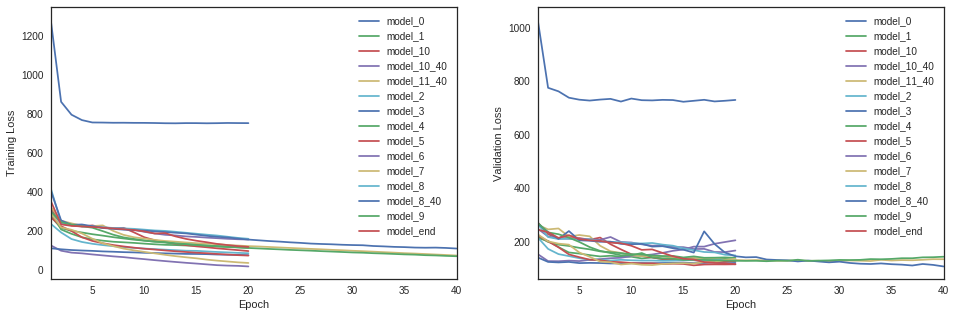

In [122]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

In [140]:
import pandas as pd
names = []
steps = []
train = []
valid = []
descriptions={
    'model_0': 'RNN',
    'model_1': 'RNN + TimeDistributed Dense',
    'model_2': 'CNN + RNN + TimeDistributed Dense',
    'model_3': 'Deeper RNN + TimeDistributed Dense',
    'model_4': 'Bidirectional RNN + TimeDistributed Dense',
    'model_5': 'deep_bidirectional_rnn_model',
    'model_6': 'Similar to mozilla deepspeech',
    'model_7': 'Similar to mozilla deepspeech with 5 recurrent layers',
    'model_8': 'deep_bidirectional_lstm_rnn_dropout_model',
    'model_8_40': 'deep_bidirectional_lstm_rnn_dropout_model',
    'model_9': 'dense_deep_bidirectional_lstm_rnn_dropout_model',
    'model_9_40': 'dense_deep_bidirectional_lstm_rnn_dropout_model',
    'model_10': 'dense_deep_bidirectional_lstm_rnn_dropout_model with 512 units',
    'model_11': 'dense_dropout_deep_bidirectional_lstm_rnn_dropout_model'
}

for i in range(len(model_names)):
    #for j in range(len(train_loss[i])):
    j = len(train_loss[i])-1
    steps.append(j+1)
    names.append(model_names[i])
    train.append(train_loss[i][j])
    valid.append(valid_loss[i][j])
        
train_flat = np.reshape(train_loss,(-1,1))
valid_flat = np.reshape(valid_loss,(-1,1))

print(train_loss[-1])
print(valid_loss[-1])

df = pd.DataFrame(data={'name': names, 'step': steps, 'training loss': train, 'validation loss': valid})

[354.63933045009395, 233.75223210172834, 226.02467634093085, 223.36829952024064, 220.46783404080372, 216.69024902919554, 213.09062122848798, 208.8929758611715, 204.94457230477963, 197.89478186841282, 186.6903483552753, 189.12995493187094, 172.00987718690118, 159.26289885898805, 149.84262984653688, 141.97483249880233, 133.38097352801628, 127.46213718630233, 122.06014568400833, 118.09455087049952]
[245.60599502563477, 235.7462173461914, 214.65306015014647, 224.87358154296874, 209.87473892211915, 205.75848205566408, 203.44730270385742, 196.684324798584, 194.71623840332032, 185.29052520751952, 169.93892868041993, 171.65932693481446, 158.63757682800292, 146.04171417236327, 136.95739562988283, 133.94973526000976, 124.31059982299804, 121.06936653137207, 120.33328361511231, 116.17603622436523]


In [139]:
df

,name,step,training loss,validation loss
0,model_0,20,753.694139,729.829296
1,model_1,20,116.944901,134.266166
2,model_10,20,96.677278,127.733286
3,model_10_40,20,17.751954,205.637288
4,model_11_40,40,73.912935,134.954290
5,model_2,20,85.654983,134.815741
6,model_3,20,75.529718,121.140794
7,model_4,20,112.873982,140.126128
8,model_5,20,73.641797,116.087536
9,model_6,20,156.065339,167.435018


__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__ Model 7 has best performance for the training set, but clearly loses in the validation set. So I added dropout to prevent overfitting and created Model 8, which performs best in the validation set. 

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W`and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [119]:
# specify the model

model_end = final_model() 

/home/andrzej/Documents/Udacity/AIND/AIND-VUI-Capstone/sample_models.py:171: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`
  inner_activation='sigmoid'),
/home/andrzej/Documents/Udacity/AIND/AIND-VUI-Capstone/sample_models.py:183: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`
  inner_activation='sigmoid'),


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_33 (Bidirectio (None, None, 400)         342400    
_________________________________________________________________
batch_normalization_36 (Batc (None, None, 400)         1600      
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 400)         0         
_________________________________________________________________
bidirectional_34 (Bidirectio (None, None, 400)         961600    
_________________________________________________________________
batch_normalization_37 (Batc (None, None, 400)         1600      
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 400)         0         
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [ ]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=False,
            optimizer='adam') # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 1652s 16s/step - loss: 354.6393 - val_loss: 245.6060
Epoch 2/20
106/106 [==============================] - 1674s 16s/step - loss: 233.7522 - val_loss: 235.7462
Epoch 3/20
106/106 [==============================] - 1675s 16s/step - loss: 226.0247 - val_loss: 214.6531
Epoch 4/20
106/106 [==============================] - 1676s 16s/step - loss: 223.3683 - val_loss: 224.8736
Epoch 5/20
106/106 [==============================] - 1685s 16s/step - loss: 220.4678 - val_loss: 209.8747
Epoch 6/20
106/106 [==============================] - 1676s 16s/step - loss: 216.6902 - val_loss: 205.7585
Epoch 7/20
106/106 [==============================] - 1681s 16s/step - loss: 213.0906 - val_loss: 203.4473
Epoch 8/20
106/106 [==============================] - 1673s 16s/step - loss: 208.8930 - val_loss: 196.6843
Epoch 9/20
106/106 [==============================] - 1676s 16s/step - loss: 204.9446 - val_loss: 194.7162
Epoch 10/20
106/106 [================

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__ I used some of the ideas given in the notebook, made the RNN part deeper (5 layers), switched from SimpleRNN to LSTM and finally added dropout to prevent overfitting.

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [130]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator(spectrogram=False)
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [136]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(), 
                model_path='results/model_end.h5')

/home/andrzej/Documents/Udacity/AIND/AIND-VUI-Capstone/sample_models.py:171: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`
  inner_activation='sigmoid'),
/home/andrzej/Documents/Udacity/AIND/AIND-VUI-Capstone/sample_models.py:183: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`
  inner_activation='sigmoid'),


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_63 (Bidirectio (None, None, 400)         342400    
_________________________________________________________________
batch_normalization_66 (Batc (None, None, 400)         1600      
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 400)         0         
_________________________________________________________________
bidirectional_64 (Bidirectio (None, None, 400)         961600    
_________________________________________________________________
batch_normalization_67 (Batc (None, None, 400)         1600      
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 400)         0         
__________

Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [137]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(), 
                model_path='results/model_end.h5')

/home/andrzej/Documents/Udacity/AIND/AIND-VUI-Capstone/sample_models.py:171: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`
  inner_activation='sigmoid'),
/home/andrzej/Documents/Udacity/AIND/AIND-VUI-Capstone/sample_models.py:183: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, recurrent_activation="sigmoid", recurrent_initializer="uniform", return_sequences=True, unit_forget_bias=True, activation="tanh", kernel_initializer="uniform")`
  inner_activation='sigmoid'),


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_68 (Bidirectio (None, None, 400)         342400    
_________________________________________________________________
batch_normalization_71 (Batc (None, None, 400)         1600      
_________________________________________________________________
dropout_29 (Dropout)         (None, None, 400)         0         
_________________________________________________________________
bidirectional_69 (Bidirectio (None, None, 400)         961600    
_________________________________________________________________
batch_normalization_72 (Batc (None, None, 400)         1600      
_________________________________________________________________
dropout_30 (Dropout)         (None, None, 400)         0         
__________

One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!